<a href="https://colab.research.google.com/github/isavida/football-task/blob/team-classification/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics -q
!pip install easyocr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.3/719.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 38.7 MB/s eta 0:00:00


In [ ]:
import colorsys
import copy
import cv2
import easyocr
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from ultralytics import YOLO

#Setup

In [ ]:
def git_setup(token):
  os.system(f"git config --global user.email 'isabel.vidaurre@hotmail.com'")
  os.system(f"git config --global user.name 'isavida'")
  os.system(f"git clone https://{token}@github.com/isavida/football-task.git")
  os.chdir("football-task")

In [ ]:
git_setup('123123')

# Introduction
The task consists of taking as input a video footage and output:


*   A JSONL file that contains a row for each 5th frame with the number of players from home-team and away-team, numbers of referees and position of the ball.
*   A video with the team players with the bounding boxes of detections
classified according to their team and the annotation of the ball when detected


It is decided to do the player detection task first, as the data for the jsonl file can be obtained from these detections.



#Players detection

In [ ]:
def inference_video(model, filename):
    results = model.track(source=f"data/{filename}.mp4", save = False, name=f"{filename}_result", conf=0.1, verbose=False)
    return results

In [ ]:
model = YOLO('yolov8n.pt')
video_capture = "clip_2"
results = inference_video(model, video_capture)

100%|██████████| 6.23M/6.23M [00:00<00:00, 298MB/s]



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



##Team classification
To correctly classify each team, the team colors should be finded.

As a first approach, is proposed to use the **k-means clustering algorithm** to detect the colors of the jerseys from the bounding boxes of the players, processing the image by removing the green background to have the maximum percentage of relevant information possible.

This approach does not provide the expected results and also does not provide the information of which equipment belongs to the home team and which to the visiting team, so it was decided to obtain all this information from the **scoreboard**.

*Although this notebook does not keep all the code that has been tested for readability, it can be consulted in previous commits.*

### Getting info from scoreboard


Considering that in the task we should distinguish between the home and the away team, another approach could be to identify the colors and the affiliation to the home or the away team by looking at the scoreboard.

In [ ]:
def get_static_pixels_from_video(filepath, n_samples=10, std_ratio = 0.04, crop_x_ratio = 0.4, crop_y_ratio = 0.2):
    ''' Crop parameters just accelerates the workflow since we know that the
    scoreboard is located at the upper-left corner. The reader can test
    this function with both crop ratios = 1, which takes around 30 secs using CPU'''
    cap = cv2.VideoCapture(filepath)

    # Randomly select n sample frames
    sample_frames_index = [np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)) for i in range(n_samples)]

    # Store selected frames in an array
    sample_frames = []
    for sfi in sample_frames_index:
        cap.set(cv2.CAP_PROP_POS_FRAMES, sfi)
        _, frame = cap.read()
        if frame is not None:
            sample_frames.append(frame[0:int(crop_y_ratio * frame.shape[0]),
                                0:int(crop_x_ratio * frame.shape[1])])

    # std will help to check static pixels
    # median obtains a precise scoreboard in case it's damaged on any frame
    std_frames = np.std(sample_frames, axis=0).astype(dtype=np.uint8)
    median_frames = np.median(sample_frames, axis=0).astype(dtype=np.uint8)

    # get mean over color channels
    std_frame_mean = np.mean(std_frames/255, axis=2)
    std_frame_mean_3D = np.repeat(std_frame_mean[:,:,np.newaxis], 3, axis=2)

    # filter static pixels
    background = np.where(std_frame_mean_3D < std_ratio, median_frames, 0)

    return background

def xywh_from_points_with_scale(points_2d, scale=1.2):
    ''' Compute center_x, center_y, width and weight given N 2d points '''

    x_min = np.min(points_2d[:,0], axis=0)
    x_max = np.max(points_2d[:,0], axis=0)
    y_min = np.min(points_2d[:,1], axis=0)
    y_max = np.max(points_2d[:,1], axis=0)

    return [(x_max+x_min)/2,
            (y_max+y_min)/2,
            (x_max-x_min) * scale,
            (y_max-y_min) * scale]

def crop_image_given_xywh(image, xywh):
    x_min = int(xywh[0] - xywh[2]/2)
    x_max = int(xywh[0] + xywh[2]/2)
    y_min = int(xywh[1] - xywh[3]/2)
    y_max = int(xywh[1] + xywh[3]/2)

    return image[y_min:y_max, x_min:x_max]

def detect_team_scoreboard_and_crop_image(background):
    # read image
    img = copy.deepcopy(background)

    # instance text detector
    reader = easyocr.Reader(['en'], gpu=False)

    # detect text on image
    text_ = reader.readtext(img)

    threshold = 0.25
    initials = []

    # draw bbox and text of team initials
    for t_, t in enumerate(text_):
        bbox, text, score = t

        if score > threshold and len(text) == 3:
            #cv2.rectangle(img, bbox[0], bbox[2], (0, 255, 0), 5)
            #cv2.putText(img, text, bbox[0], cv2.FONT_HERSHEY_COMPLEX, 0.65, (255, 0, 0), 2)

            initials.append(bbox)

    initials_np = np.array(initials)
    initials_np = initials_np.reshape(initials_np.shape[0] * initials_np.shape[1], initials_np.shape[2])

    xywh = xywh_from_points_with_scale(initials_np)
    crop_img = crop_image_given_xywh(img, xywh)

    return crop_img


In [ ]:
def split_scoreboard_per_team(scoreboard):
    img_width = scoreboard.shape[1]
    return scoreboard[:,:img_width//2,:], scoreboard[:,img_width//2:,:]

In [ ]:
def quantize_img(img, K=32):
    ''' This function quantize the input image by using k-means algorithm,
        dividing the input image in the K most-predominant colors'''
    # Preprocess input img
    Z = img.reshape((-1,3))
    Z = np.float32(Z)

    # Specify stopping criteria, max_iters and desired-accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    #(samples,nclusters,None,criteria,attempts,flags)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Postprocess back img to original structure
    center = np.uint8(center)
    res = center[label.flatten()]
    quantized_img = res.reshape((img.shape))

    return quantized_img

In [ ]:
def display_dominant_colors(dominant_colors):
    # Create a blank white image
    bar = np.zeros((50, 300, 3), dtype=np.uint8)
    startX = 0

    # For each dominant color, draw a rectangle on the blank image
    for color in dominant_colors:
        endX = startX + (300 // len(dominant_colors))
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype(int).tolist(), -1)
        startX = endX

    # Display the image
    cv2_imshow(bar)

In [ ]:
def get_color_frequencies(img):
    ''' Get color frequencies and return pd dataframe '''

    img_nx3 = np.float32(img.reshape(-1, 3))

    unique_pixels, counts = np.unique(img_nx3, axis=0, return_counts=True)

    color_dict = {'color': [tuple(color) for color in unique_pixels],
                  'frequency': counts}

    return pd.DataFrame(color_dict)

def get_most_distinctive_color(color_freq_home, color_freq_away, ratio=10):
  df_merged = pd.merge(color_freq_home, color_freq_away, on='color', suffixes=('_df1', '_df2'), how='outer')

  # Compute difference between frequencies in both dataframes
  df_merged['frequency_difference'] = abs(df_merged['frequency_df1']/df_merged['frequency_df2'])

  # If the frequencies are bigger than ratio or lower than 1/ratio or Nan(meaning that the color is in one side, but not in the other) is considered a difference to consider
  outstanding_differences = df_merged[
    (df_merged['frequency_difference'] > ratio) |
    (df_merged['frequency_difference'] < 1/ratio) |
    (df_merged['frequency_difference'].isna())
  ]

  # Retrieve the rows with the most frequency for each df from these differences
  max_frequency_df1 = outstanding_differences.loc[outstanding_differences['frequency_df1'].idxmax()]
  max_frequency_df2 = outstanding_differences.loc[outstanding_differences['frequency_df2'].idxmax()]

  return max_frequency_df1['color'], max_frequency_df2['color']


In [ ]:
def get_color_per_team_from_video(filepath, kmeans_nclusters=32, color_freq_ratio=10):
    ''' Workflow which takes a video as input and return the color assigned to home and away team '''

    # Extract scoreboard from video
    background = get_static_pixels_from_video(filepath)
    scoreboard = detect_team_scoreboard_and_crop_image(background)

    # Quantize scoreboard and split in home-away teams
    quantized_scoreboard = quantize_img(scoreboard, kmeans_nclusters)
    quantized_home_scoreboard, quantized_away_scoreboard = split_scoreboard_per_team(quantized_scoreboard)

    # Get color frequency per team
    color_frequencies_home_scoreboard = get_color_frequencies(quantized_home_scoreboard)
    color_frequencies_away_scoreboard = get_color_frequencies(quantized_away_scoreboard)

    # Get the most used color in a team that is mostly never used in the other team
    return get_most_distinctive_color(color_frequencies_home_scoreboard, color_frequencies_away_scoreboard, color_freq_ratio)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete(50.0, 16.0, 213.0) (105.0, 54.0, 33.0)


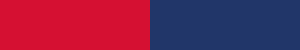

In [ ]:
filepath = f"data/{video_capture}.mp4"
home_color, away_color = get_color_per_team_from_video(filepath)

print(home_color, away_color)
display_dominant_colors([np.array(home_color), np.array(away_color)])

###Players classification
Once we have obtained from the scoreboard the color of the home team and the color of the away team, we use the OpenCV *cv2.inRange* method to detect the colors in the jerseys that are in a range around the colors of the teams.


This process is performed in the HSV color space, as it allows a better color separation and to take into account aspects such as brightness and saturation, which are important for color detection.

In [ ]:
def get_color_boundaries(color):
  h, s, v= colorsys.rgb_to_hsv(color[2], color[1], color[0]) #obtain hsv values from color
  # translate into opencv space
  h = int(180*h)
  s = int(255*s)
  v = int(v)

  low_h=h-20
  top_h=h+20
  additionalMask = False

  # h coordinates are circular, we have to consider this for red color
  if low_h < 0:
    new_low_h = low_h + 180
    new_top_h = 180
    low_h = 0
    additionalMask = True
  elif top_h>180:
    new_top_h = top_h - 180
    new_low_h = 0
    top_h = 180
    additionalMask = True

  lower_bound = np.array([low_h, np.clip(s-90,0,255), np.clip(v-90,0,255)])
  upper_bound = np.array([top_h, np.clip(s+90,0,255), np.clip(v+90,0,255)])

  if additionalMask:
    additional_lower_bound = np.array([new_low_h, np.clip(s-90,0,255), np.clip(v-90,0,255)])
    additional_upper_bound = np.array([new_top_h, np.clip(s+90,0,255), np.clip(v+90,0,255)])
    return lower_bound, upper_bound, additional_lower_bound, additional_upper_bound

  return lower_bound, upper_bound

def get_mask(player_hsv, boundaries):

  mask = cv2.inRange(player_hsv, boundaries[0], boundaries[1])

  if len(boundaries)==4:
    mask1 = cv2.inRange(player_hsv, boundaries[2], boundaries[3])
    mask = mask + mask1

  return mask

def team_classification(player, ht_color_boundaries, at_color_boundaries, debug=False):

  kernel = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])

  # apply a filter to enhance color differences (specially in stripes)
  sharpened_player = cv2.filter2D(player, -1, kernel)
  player_hsv = cv2.cvtColor(sharpened_player,cv2.COLOR_BGR2HSV)

  output_ht = cv2.bitwise_and(player_hsv,player_hsv,mask=get_mask(player_hsv, ht_color_boundaries))
  ht_count = np.count_nonzero(output_ht)

  output_at = cv2.bitwise_and(player_hsv,player_hsv,mask=get_mask(player_hsv, at_color_boundaries))
  at_count = np.count_nonzero(output_at)

  tot_count = np.count_nonzero(player_hsv)

  if debug:
    cv2_imshow(player_hsv)

    print('Percentage of pixels home team : ', ht_count/tot_count)
    cv2_imshow(output_ht)

    print('Percentage of pixels away team  : ', at_count/tot_count)
    cv2_imshow(output_at)


  if ht_count/tot_count>0.01:
    print('Home Team detection')
    print('--------------------------------')
    return 'Home Team'

  elif at_count/tot_count>0.01:
    print('Away Team detection')
    print('--------------------------------')
    return 'Away Team'

  else:
    print('Not sure detection')
    print('--------------------------------')
    return 'Not sure', (0, 0, 0)


In [ ]:
def get_upper_left_corner_location(coordinates):
  ''' YOLO x-y coordinates refers to the center of the detected image.
  This functions gets the upper-left corner as a util in order to create the mask of the bounding boxes '''
  center_x, center_y, w, h = coordinates
  x= int(center_x - w/2)
  y= int(center_y - h/2)

  return x, y


In [ ]:
def get_torso_images(orig_img, bounding_boxes):
  persons=[]
  ## remove green
  hsv = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
  green_mask = cv2.inRange(hsv, (35, 35, 35), (70, 255,255))
  inverted_green_mask= cv2.bitwise_not(green_mask)
  processed_img = cv2.bitwise_and(orig_img,orig_img, mask=inverted_green_mask)

  for box in bounding_boxes:
    x, y, w, h=map(int, box.xywh.tolist()[0])
    x,y = get_upper_left_corner_location([int(x),y,w,h])

    if box.cls==0: #cls 0 corresponds to person
      person=processed_img[y:y+(h//2),x:x+w]
      persons.append(person)

  return persons

In [ ]:
#Obtaining the frame with more person detections
max=0
max_id=0
for i,r in enumerate(results):
  length = len(r.boxes.cls==0)
  if length>max:
    max=length
    max_id=i

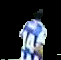

In [ ]:
persons=get_torso_images(results[max_id].orig_img, results[max_id].boxes)
person=persons[0]
cv2_imshow(person)

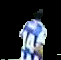

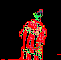

Porcentaje de ht :  0.0


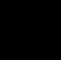

Porcentaje de at :  0.17687074829931973


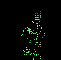

Away Team detection
--------------------------------


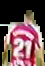

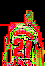

Porcentaje de ht :  0.16551921973608721


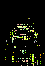

Porcentaje de at :  0.008605851979345954


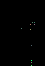

Home Team detection
--------------------------------


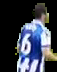

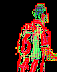

Porcentaje de ht :  0.004099480732440558


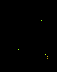

Porcentaje de at :  0.21727247881934955


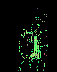

Away Team detection
--------------------------------


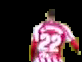

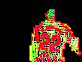

Porcentaje de ht :  0.21602689829083777


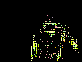

Porcentaje de at :  0.021854861305687867


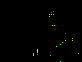

Home Team detection
--------------------------------


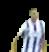

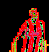

Porcentaje de ht :  0.017306652244456464


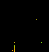

Porcentaje de at :  0.11357490535424554


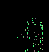

Home Team detection
--------------------------------


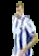

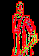

Porcentaje de ht :  0.020224719101123594


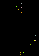

Porcentaje de at :  0.13314606741573035


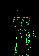

Home Team detection
--------------------------------


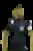

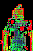

Porcentaje de ht :  0.009819967266775777


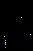

Porcentaje de at :  0.18412438625204583


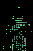

Away Team detection
--------------------------------


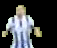

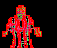

Porcentaje de ht :  0.0018181818181818182


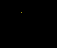

Porcentaje de at :  0.13090909090909092


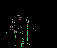

Away Team detection
--------------------------------


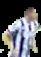

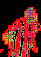

Porcentaje de ht :  0.0


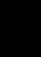

Porcentaje de at :  0.11635345861655338


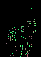

Away Team detection
--------------------------------


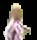

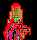

Porcentaje de ht :  0.028368794326241134


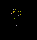

Porcentaje de at :  0.016548463356973995


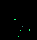

Home Team detection
--------------------------------


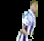

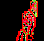

Porcentaje de ht :  0.0034129692832764505


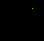

Porcentaje de at :  0.10580204778156997


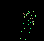

Away Team detection
--------------------------------


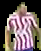

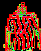

Porcentaje de ht :  0.04841628959276018


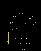

Porcentaje de at :  0.01764705882352941


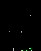

Home Team detection
--------------------------------


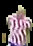

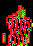

Porcentaje de ht :  0.03211009174311927


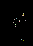

Porcentaje de at :  0.01834862385321101


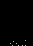

Home Team detection
--------------------------------


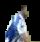

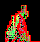

Porcentaje de ht :  0.004467609828741623


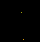

Porcentaje de at :  0.22338049143708116


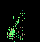

Away Team detection
--------------------------------


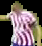

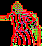

Porcentaje de ht :  0.02375407545412203


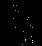

Porcentaje de at :  0.025151374010246856


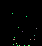

Home Team detection
--------------------------------


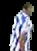

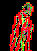

Porcentaje de ht :  0.009389671361502348


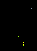

Porcentaje de at :  0.14285714285714285


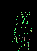

Away Team detection
--------------------------------


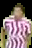

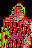

Porcentaje de ht :  0.02889576883384933


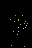

Porcentaje de at :  0.021671826625386997


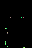

Home Team detection
--------------------------------


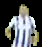

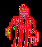

Porcentaje de ht :  0.001973684210526316


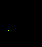

Porcentaje de at :  0.09078947368421053


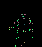

Away Team detection
--------------------------------


In [ ]:
ht_boundaries = get_color_boundaries(home_color)
at_boundaries = get_color_boundaries(away_color)

for player in persons:
  cv2_imshow(player)
  _ = team_classification(player, ht_boundaries, at_boundaries)

